In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import scipy
import scipy.io

import seaborn as sns
import matplotlib.pyplot as plt

from rpy2.robjects import r
from rpy2.robjects import pandas2ri

import anndata2ri

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

During startup - Warning message:
Setting LC_CTYPE failed, using "C" 


In [2]:
%%R
suppressPackageStartupMessages({
    library(SingleCellExperiment)
    library(Seurat)
})


    consider that it could be called from a Python process. This
    results in a quasi-obligatory segfault when rpy2 is evaluating
    R code using it. On the hand, rpy2 is accounting for the
    fact that it might already be running embedded in a Python
    process. This is why:
    - Python -> rpy2 -> R -> reticulate: crashes
    - R -> reticulate -> Python -> rpy2: works

    The issue with reticulate is tracked here:
    https://github.com/rstudio/reticulate/issues/208
    

In [3]:
%%R
options(future.globals.maxSize = 32000 * 1024^2)

# Expressions

## Load the data

In [4]:
rna = sc.read('../../../data/hao-2020/expressions_hvg.h5ad')
rna

AnnData object with n_obs × n_vars = 149926 × 4000
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'predicted.celltype.l1', 'predicted.celltype.l2', 'predicted.celltype.l3'
    var: 'names', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Batch_colors', 'celltype.l1_colors', 'celltype.l2_colors', 'celltype.l3_colors', 'donor_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [5]:
adata_ = ad.AnnData(rna.layers['count'])
adata_.obs_names = rna.obs_names
adata_.var_names = rna.var_names
adata_.obs['cell_type'] = rna.obs['celltype.l2']
adata_.obs['batch'] = rna.obs['Batch']

In [6]:
%%R -i adata_
rna = as.Seurat(adata_, counts='X', data=NULL)
rna

An object of class Seurat 
4000 features across 149926 samples within 1 assay 
Active assay: originalexp (4000 features, 0 variable features)


# Protein

## Download the data

In [7]:
adt = sc.read('../../../data/hao-2020/protein.h5ad')
adt

AnnData object with n_obs × n_vars = 149926 × 228
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'predicted.celltype.l1', 'predicted.celltype.l2', 'predicted.celltype.l3'
    var: 'n_cells'
    uns: 'Batch_colors', 'celltype.l1_colors', 'celltype.l2_colors', 'celltype.l3_colors', 'donor_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [8]:
adata_ = ad.AnnData(adt.layers['count'])
adata_.obs_names = adt.obs_names
adata_.var_names = adt.var_names
adata_.obs['cell_type'] = adt.obs['celltype.l2']
adata_.obs['batch'] = adt.obs['Batch']

In [9]:
%%R -i adata_
cite = as.Seurat(adata_, counts='X', data=NULL)
cite

An object of class Seurat 
228 features across 149926 samples within 1 assay 
Active assay: originalexp (228 features, 0 variable features)


# Integrate RNA batches

In [10]:
%%R
rna <- RenameAssays(rna, originalexp="RNA")
rna.list <- SplitObject(rna, split.by = "batch")
rna.list <- lapply(X = rna.list, FUN = SCTransform, variable.features.n = 1000)
features <- SelectIntegrationFeatures(object.list = rna.list, nfeatures = 1000)
rna.list <- PrepSCTIntegration(object.list = rna.list, anchor.features = features)

R[write to console]: Renaming default assay from originalexp to RNA

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 3204 by 64344

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 5000 cells



  |======================================================================| 100%


R[write to console]: Found 32 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 3204 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 3204 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 3.101601 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: Set default assay to SCT

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 3341

  |======================================================================| 100%


R[write to console]: There are 4 estimated thetas smaller than 1e-07 - will be set to 1e-07

R[write to console]: Found 29 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 3341 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 3341 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 3.08367 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: Set default assay to SCT



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~06s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=13s  


In [11]:
%%R
anchors <- FindIntegrationAnchors(object.list = rna.list, normalization.method = "SCT", 
    anchor.features = features)

R[write to console]: Finding all pairwise anchors



  |                                                  | 0 % ~calculating  

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 135336 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 64127 anchors



  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01h 34m 03s


In [12]:
%%R
integrated <- IntegrateData(anchorset = anchors, normalization.method = "SCT")

R[write to console]: Merging dataset 1 into 2

R[write to console]: Extracting anchors for merged samples

R[write to console]: Finding integration vectors

R[write to console]: Finding integration vector weights

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to con

In [13]:
%%R
integrated <- RunPCA(integrated)

R[write to console]: PC_ 1 
Positive:  GNLY, NKG7, CCL5, GZMA, GZMB, CST7, PRF1, FGFBP2, KLRD1, GZMH 
	   CTSW, SYNE2, KLRB1, CD247, KLRF1, SPON2, HOPX, IL32, GZMM, TRDC 
	   CD7, CLIC3, ADGRG1, PYHIN1, IL2RB, MYBL1, ARL4C, CD2, SAMD3, SYNE1 
Negative:  S100A8, S100A9, VCAN, FOS, IL1B, G0S2, FTL, LYZ, FCN1, CST3 
	   FTH1, MNDA, S100A12, CXCL8, CCL3, HLA-DRA, AIF1, CD14, TNFAIP2, NAMPT 
	   AC020656.1, MARCKS, CCL3L1, LST1, THBS1, CYBB, NFKBIA, SAT1, IER3, SOD2 
PC_ 2 
Positive:  IL7R, LTB, TCF7, MS4A1, CD79A, TRAC, IGHM, RPS27, TRBC2, CCR7 
	   IGKC, RPS12, CD3D, LEF1, RALGPS2, BANK1, RCAN3, CXCR4, NOSIP, MAL 
	   CD27, CAMK4, IGHD, TRBC1, CD69, CD79B, RPS26, BCL11B, TRABD2A, OXNAD1 
Negative:  GNLY, NKG7, S100A8, GZMB, IL1B, G0S2, CCL3, PRF1, FGFBP2, S100A9 
	   CCL4, VCAN, CST7, GZMA, CCL5, KLRD1, LYZ, CXCL8, GZMH, FOS 
	   FCGR3A, FTL, FCN1, S100A12, FTH1, CCL3L1, KLRF1, CST3, SPON2, MNDA 
PC_ 3 
Positive:  IL7R, TRAC, CD3D, TCF7, TRBC2, TRBC1, IL32, LEF1, NOSIP, MAL 
	   BCL11B, C

In [14]:
%%R
saveRDS(integrated, file='integrated_rna_hao.rds')

# Integrate ADT batches

In [15]:
%%R
cite <- RenameAssays(cite, originalexp='ADT')

cite.list <- SplitObject(cite, split.by = "batch")

cite.list <- lapply(X = cite.list, FUN = function(x) {
    VariableFeatures(x) <- rownames(x[["ADT"]])
    x <- NormalizeData(x, normalization.method = 'CLR', margin = 2, verbose=FALSE)
})

features <- SelectIntegrationFeatures(object.list = cite.list)

cite.list <- lapply(X = cite.list, FUN = function(x) {
    x <- ScaleData(x, features = features, verbose=FALSE)
    x <- RunPCA(x, features = features, reduction.name = "pca", verbose=FALSE)
})

anchors <- FindIntegrationAnchors(object.list = cite.list, reduction = "rpca", 
    dims = 1:30, verbose=FALSE)
integrated_adt <- IntegrateData(anchorset = anchors, dims = 1:30)

integrated_adt <- ScaleData(integrated_adt, verbose=FALSE)
integrated_adt <- RunPCA(integrated_adt, reduction.name = "apca", verbose=FALSE)

R[write to console]: Renaming default assay from originalexp to ADT



  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=48s  


R[write to console]: Merging dataset 1 into 2

R[write to console]: Extracting anchors for merged samples

R[write to console]: Finding integration vectors

R[write to console]: Finding integration vector weights

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to con

In [16]:
%%R
saveRDS(integrated_adt, file='integrated_adt_hao.rds')

# Run Seurat v4 WNN
Following https://satijalab.org/seurat/v4.0/weighted_nearest_neighbor_analysis.html.

In [17]:
%%R
integrated[["IADT"]] <- integrated_adt[["integrated"]]
integrated[["apca"]] <- integrated_adt[["apca"]]

integrated <- FindMultiModalNeighbors(integrated, reduction.list = list("pca", "apca"), 
                              dims.list = list(1:50, 1:30), modality.weight.name = "RNA.weight")

integrated <- RunSPCA(integrated, assay = 'integrated', graph = 'wsnn', npcs = 20)

R[write to console]: Calculating cell-specific modality weights

R[write to console]: Finding 20 nearest neighbors for each modality.



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~42s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01m 21s


R[write to console]: Calculating kernel bandwidths



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~13s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=24s  


R[write to console]: Finding multimodal neighbors



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~02m 41s       |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=05m 13s
  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~23s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=33s  


R[write to console]: Constructing multimodal KNN graph

R[write to console]: Constructing multimodal SNN graph

R[write to console]: Computing sPCA transformation



In [18]:
%%R -o spca
spca = Embeddings(object = integrated[["spca"]])

In [19]:
adata = sc.AnnData(spca)
adata.obs = adata_.obs
adata

AnnData object with n_obs × n_vars = 149926 × 20
    obs: 'cell_type', 'batch'

In [20]:
%%R -o wnn
wnn <- as.data.frame(summary(integrated@graphs$wknn))

In [21]:
wnn['i'] = wnn['i'] - 1
wnn['j'] = wnn['j'] - 1

In [22]:
adata.obsp['wnn_connectivities'] = scipy.sparse.coo_matrix((wnn['x'], (wnn['i'], wnn['j'])))
adata.obsp['wnn_connectivities'] = scipy.sparse.csr_matrix(adata.obsp['wnn_connectivities'])

In [23]:
adata.write('hao-seurat.h5ad')

# Visualize results

In [24]:
sc.pp.neighbors(adata)
adata.obsp['connectivities'] = adata.obsp['wnn_connectivities'].copy()
# delete distances to make sure we are not using anything calculated with sc.pp.neighbors()
del adata.obsp['distances']
sc.tl.umap(adata)

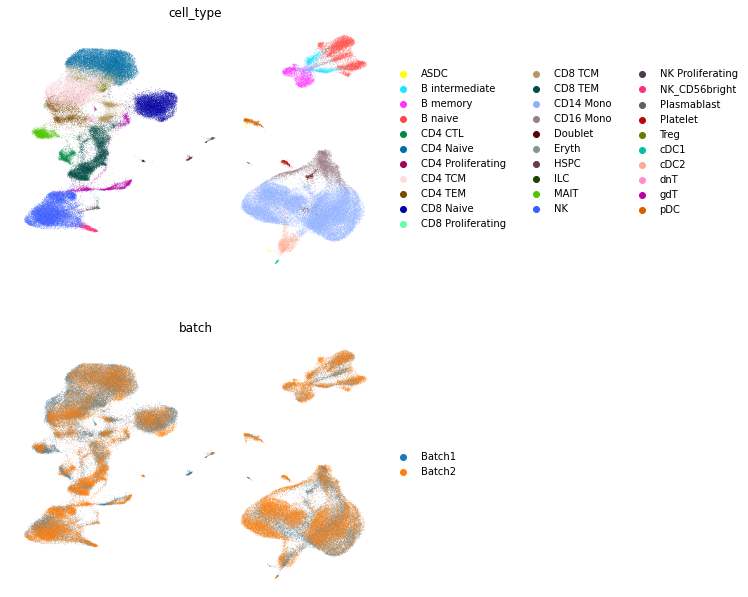

In [25]:
sc.pl.umap(adata, color=['cell_type', 'batch'], ncols=1, frameon=False, save='hao-seurat.png')

In [26]:
%%R
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/bridge/lib/libopenblasp-r0.3.20.so

locale:
 [1] LC_CTYPE=C                 LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] Matrix_1.4-1                sp_1.5-0                   
 [3] SeuratObject_4.1.0          Seurat_4.1.1.9001          
 [5] SingleCellExperiment_1.16.0 SummarizedExperiment_1.24.0
 [7] Biobase_2.54.0              GenomicRanges_1.46.1 